In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules

# Chargement
df = pd.read_csv('../HR_Analytics_Structure_Complet.csv')

# --- CRÉATION DE DIMENSIONS CRÉATIVES ---
df_creative = pd.DataFrame()

# 1. Équilibre (Work-Life Balance)
df_creative['Equilibre_Sain'] = df['WorkLifeBalance'].apply(lambda x: True if x >= 3 else False)
df_creative['Pas_Heures_Sup'] = df['OverTime'].apply(lambda x: True if x == 'No' else False)

# 2. Climat Social (Environment & Relationship)
df_creative['Bon_Environnement'] = df['EnvironmentSatisfaction'].apply(lambda x: True if x >= 3 else False)
df_creative['Bonnes_Relations'] = df['RelationshipSatisfaction'].apply(lambda x: True if x >= 3 else False)

# 3. Épanouissement (Involvement & Job Satisfaction)
df_creative['Tres_Engagé'] = df['JobInvolvement'].apply(lambda x: True if x >= 3 else False)
df_creative['HAUTE_SATISFACTION'] = df['JobSatisfaction'].apply(lambda x: True if x >= 4 else False)

# 4. Contexte de Carrière
df_creative['Niveau_Expert'] = df['JobLevel'].apply(lambda x: True if x >= 3 else False)
df_creative['Dep_' + df['Department']] = True # Encodage auto des départements

# On remplit les NaNs par False (cas des départements)
df_creative = df_creative.fillna(False)

print("Dimensions créatives créées. Analyse des 'Micro-Climats' en cours...")

Dimensions créatives créées. Analyse des 'Micro-Climats' en cours...


In [3]:
# 1. Application d'Apriori avec un support plus bas (0.02 au lieu de 0.05) pour être plus sensible
frequent_itemsets = apriori(df_creative, min_support=0.02, use_colnames=True)

# 2. Génération des règles
# Si aucune règle n'est trouvée avec lift=1.1, on baisse à 1.0
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# 3. Vérification si des règles existent
if not rules.empty:
    # Filtrer pour le but ultime : La Haute Satisfaction
    # On utilise .str.contains pour plus de robustesse sur les types "frozenset"
    satisfaction_rules = rules[rules['consequents'].apply(lambda x: 'HAUTE_SATISFACTION' in x)]
    
    if not satisfaction_rules.empty:
        # Trier par confiance
        satisfaction_rules = satisfaction_rules.sort_values(by='confidence', ascending=False)
        print(f"✅ {len(satisfaction_rules)} chemins vers le bonheur trouvés.")
    else:
        print("⚠️ Aucune règle spécifique menant à 'HAUTE_SATISFACTION' n'a été trouvée.")
        satisfaction_rules = pd.DataFrame() # Créer un DF vide pour éviter les erreurs plus loin
else:
    print("❌ Aucune règle d'association trouvée. Essayez de baisser 'min_support' dans apriori().")
    satisfaction_rules = pd.DataFrame()

✅ 3550 chemins vers le bonheur trouvés.


C:\Users\DELL\AppData\Roaming\Python\Python313\site-packages\mlxtend\frequent_patterns\association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


C:\Users\DELL\AppData\Local\Temp\ipykernel_5576\2151606417.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='lift', y='antecedents_str', data=top_rules, palette='viridis')
C:\Users\DELL\AppData\Local\Temp\ipykernel_5576\2151606417.py:19: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\DELL\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


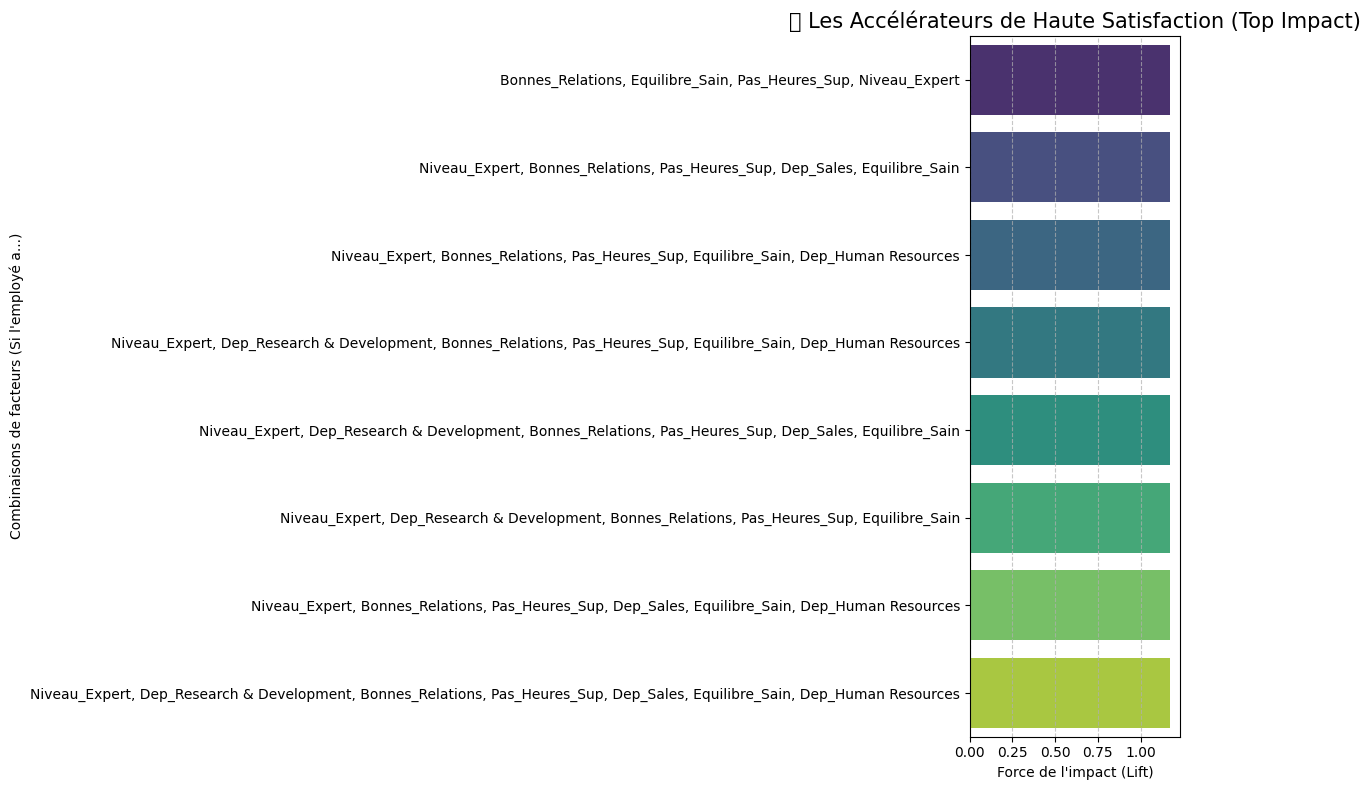

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

if not satisfaction_rules.empty:
    # On prend les 10 meilleures règles pour la visualisation
    top_rules = satisfaction_rules.head(10).copy()
    
    # Transformation des antécédents en texte lisible pour l'axe Y
    top_rules['antecedents_str'] = top_rules['antecedents'].apply(lambda x: ', '.join(list(x)))

    plt.figure(figsize=(12, 8))
    # Utilisation d'une palette de couleurs dégradée
    sns.barplot(x='lift', y='antecedents_str', data=top_rules, palette='viridis')
    
    plt.title('🚀 Les Accélérateurs de Haute Satisfaction (Top Impact)', fontsize=15)
    plt.xlabel('Force de l\'impact (Lift)')
    plt.ylabel('Combinaisons de facteurs (Si l\'employé a...)')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("Graphique impossible : le jeu de règles est vide.")

🏆 PODIUM DES FACTEURS DE SATISFACTION
Ce classement montre quels facteurs reviennent le plus souvent dans les profils d'employés heureux.
------------------------------------------------------------


,Facteur_RH,Nombre_de_Regles_Gagnantes
0,Bonnes_Relations,432
3,Niveau_Expert,432
2,Pas_Heures_Sup,243
4,Dep_Sales,225
6,Dep_Research & Development,225
5,Dep_Human Resources,225
1,Equilibre_Sain,216
7,Tres_Engagé,27


C:\Users\DELL\AppData\Local\Temp\ipykernel_5576\2911815731.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Nombre_de_Regles_Gagnantes', y='Facteur_RH', data=df_ranking, palette='coolwarm')
C:\Users\DELL\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


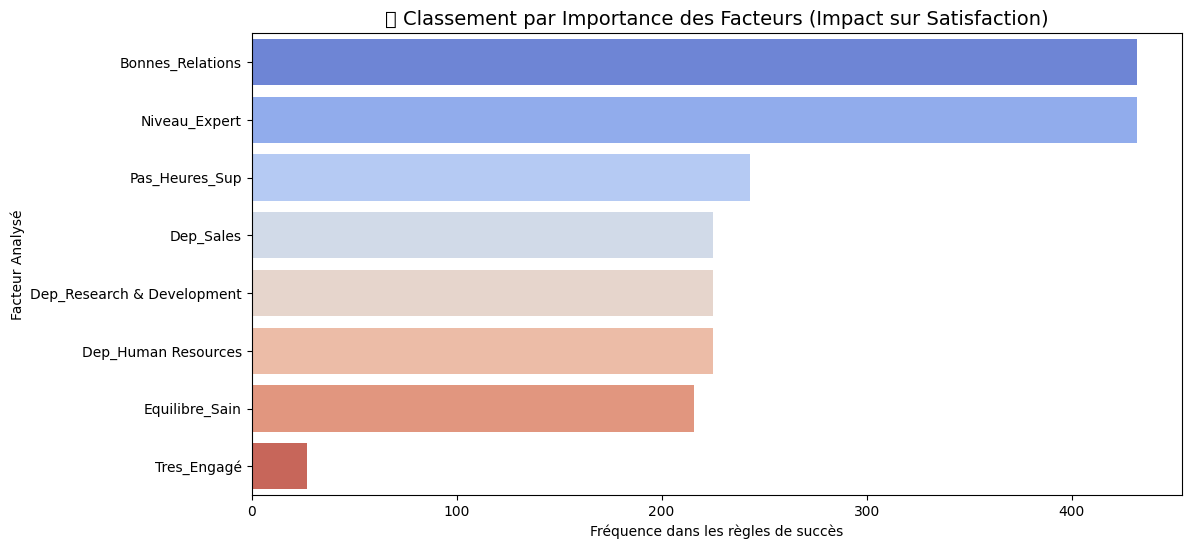

In [5]:
from collections import Counter

# 1. Sélectionner les règles avec un impact réel (Lift > 1.1)
# On se concentre sur les chemins qui mènent à la HAUTE_SATISFACTION
rules_for_ranking = satisfaction_rules[satisfaction_rules['lift'] > 1.1]

# 2. Extraire tous les facteurs individuels des antécédents
all_factors = []
for itemset in rules_for_ranking['antecedents']:
    all_factors.extend(list(itemset))

# 3. Compter la fréquence d'apparition de chaque facteur
importance_counts = Counter(all_factors)

# 4. Transformer en DataFrame pour un affichage propre
df_ranking = pd.DataFrame(importance_counts.items(), columns=['Facteur_RH', 'Nombre_de_Regles_Gagnantes'])
df_ranking = df_ranking.sort_values(by='Nombre_de_Regles_Gagnantes', ascending=False)

# 5. Affichage du Classement
print("🏆 PODIUM DES FACTEURS DE SATISFACTION")
print("Ce classement montre quels facteurs reviennent le plus souvent dans les profils d'employés heureux.")
print("-" * 60)
display(df_ranking.style.background_gradient(cmap='Greens'))

# 6. Visualisation Graphique
plt.figure(figsize=(12, 6))
sns.barplot(x='Nombre_de_Regles_Gagnantes', y='Facteur_RH', data=df_ranking, palette='coolwarm')
plt.title('📊 Classement par Importance des Facteurs (Impact sur Satisfaction)', fontsize=14)
plt.xlabel('Fréquence dans les règles de succès')
plt.ylabel('Facteur Analysé')
plt.show()

In [26]:
def tester_satisfaction_employe(profil, regles_satisfaction):
    """
    Version Finale : Intègre des BONUS pour les scores parfaits (4/4).
    """
    
    # --- 1. Traduction (Tags Apriori) ---
    features_employe = set()
    if 'Departement' in profil: features_employe.add(f"Dep_{profil['Departement']}")
    if profil.get('JobLevel', 1) >= 3: features_employe.add('Niveau_Expert')
    else: features_employe.add('Niveau_Junior')
    if profil.get('Heures_Sup') == 'Non': features_employe.add('Pas_Heures_Sup')
    if profil.get('Equilibre_Vie', 1) >= 3: features_employe.add('Equilibre_Sain')
    if profil.get('Environnement', 1) >= 3: features_employe.add('Bon_Environnement')
    if profil.get('Implication', 1) >= 3: features_employe.add('Tres_Engage')
    
    # --- 2. Score de Base via Apriori ---
    score_max = 5.0 # On part de 5 (Moyenne)
    regles_activees = []
    
    for idx, row in regles_satisfaction.iterrows():
        if row['antecedents'].issubset(features_employe):
            lift = row['lift']
            # Logique : Plus la règle est forte, plus la base est haute
            score_regle = 6.0
            if lift > 1.1: score_regle += 1.0  # -> 7.0
            if lift > 1.3: score_regle += 0.5  # -> 7.5
            
            if score_regle > score_max:
                score_max = score_regle
            regles_activees.append(row)

    score_final = score_max

    # --- 3. LES BONUS D'EXCELLENCE (Nouveau !) 🚀 ---
    # Si l'utilisateur a mis le score MAX (4), on booste la note.
    
    # Bonus : Environnement Excellent (4)
    if profil.get('Environnement') == 4:
        print("✨ Bonus : Environnement Excellent (+1.0 pt)")
        score_final += 1.0
        
    # Bonus : Équilibre Parfait (4)
    if profil.get('Equilibre_Vie') == 4:
        print("✨ Bonus : Équilibre Vie Pro Parfait (+1.0 pt)")
        score_final += 1.0
        
    # Bonus : Implication Totale (4)
    if profil.get('Implication') == 4:
        print("✨ Bonus : Implication Totale (+0.5 pt)")
        score_final += 0.5

    # --- 4. LES PÉNALITÉS (Comme avant) ---
    if 'Pas_Heures_Sup' not in features_employe:
        score_final -= 1.5 # Pénalité Heures Sup
        
    if 'Bon_Environnement' not in features_employe:
        score_final -= 2.0 # Pénalité Environnement < 3
        
    if 'Equilibre_Sain' not in features_employe:
        score_final -= 1.5 # Pénalité Equilibre < 3

    # --- 5. Verdict ---
    score_final = max(0, min(10, score_final)) # Bornage 0-10
    score_final = round(score_final, 1)
    
    verdict = "INSATISFAIT 😟"
    if score_final >= 8.0: verdict = "TRÈS SATISFAIT 🤩" # Seuil monté à 8
    elif score_final >= 6.0: verdict = "SATISFAIT 🙂"
    elif score_final >= 4.0: verdict = "NEUTRE 😐"
    
    return score_final, verdict, len(regles_activees)

In [35]:
# ==============================================================================
# ZONE DE TEST (Modifiez les valeurs ci-dessous)
# ==============================================================================

profil_test = {
    'Departement': 'Sales', # Options : 'Sales', 'Research & Development', 'Human Resources'
    'JobLevel': 1,                    # Options : 1 à 5
    'Heures_Sup': 'Oui',              # Options : 'Oui' ou 'Non'
    'Equilibre_Vie': 1,               # Options : 1 (Mauvais), 2 (Moyen), 3 (Bon), 4 (Excellent)
    'Environnement': 1,               # Options : 1 (Faible), 2 (Moyen), 3 (Élevé), 4 (Très Élevé)
    'Implication': 1                  # Options : 1 (Faible), 2 (Moyen), 3 (Forte), 4 (Très Forte)
}

# --- Exécution ---
print("-" * 60)
print("🤖 SIMULATION DE SATISFACTION")
print("-" * 60)

# Appel de la fonction
note, message, nb_regles = tester_satisfaction_employe(profil_test, satisfaction_rules)

print("\n" + "="*30)
print(f"🎯 SCORE FINAL : {note} / 10")
print(f"📢 VERDICT : {message}")
print("="*30)
print(f"ℹ️ Note : Ce profil correspondait techniquement à {nb_regles} règles positives,")
print("mais les pénalités (environnement/heures sup) ont fait chuter la note.")

------------------------------------------------------------
🤖 SIMULATION DE SATISFACTION
------------------------------------------------------------

🎯 SCORE FINAL : 1.0 / 10
📢 VERDICT : INSATISFAIT 😟
ℹ️ Note : Ce profil correspondait techniquement à 196 règles positives,
mais les pénalités (environnement/heures sup) ont fait chuter la note.


In [36]:
import joblib

# On suppose que 'satisfaction_rules' est le DataFrame final que vous avez filtré
# et qui contient les colonnes 'antecedents', 'consequents', 'lift', etc.

print("💾 Sauvegarde des règles Apriori pour l'application...")

# On sauvegarde uniquement le DataFrame des règles (c'est ça le "modèle" en Apriori)
# On utilise pickle car il conserve bien le format des "sets" (frozenset) d'Apriori
satisfaction_rules.to_pickle("regles_satisfaction.pkl")

print("✅ Fichier 'regles_satisfaction.pkl' généré avec succès !")


💾 Sauvegarde des règles Apriori pour l'application...
✅ Fichier 'regles_satisfaction.pkl' généré avec succès !
